In [97]:
#TESTING GIT AND GITHUB LETS SEE IF THIS WORKS
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import DateOffset

In [98]:
start_date='2007-01-01'
Ticker = 'HOOD'

PeriodMultiplier = 18
range_window = 127 # Trading days
vol_window = PeriodMultiplier * range_window # 3 years for a 60 day range window


#Trading Days use 365 for crypto
TradingDays = 255   

# For Compression Scores
compression_vol_filter = -0.1
compression_range_filter = 0.1
z_score = 1  # 68% confidence

# For Stop Strategy
StopMagnitude = 1.5

# For Exit Strategy
MovingAverage = 50
# Set end_date to today's date
end_date = datetime.now().strftime('%Y-%m-%d')



TESTING GITHUB AND GIT LETS SEE IF THIS WORKS LETS SEEEE

TESTING WITH FILE SAVE

In [99]:

def GetData(start_date):
    """Download price data from Yahoo Finance"""
    data = yf.download(
            Ticker,
            start=start_date,
            end=end_date,
            auto_adjust=False,  # Use raw closing prices (not adjusted for dividends and splits)
            progress=False
        )
    # Extract closing prices and remove NA values
    data = data['Close'].dropna()
    return data

# Download the data
data = GetData(start_date)
print(f"Downloaded {len(data)} days of {Ticker} price data")
print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")

Downloaded 954 days of HOOD price data
Date range: 2021-07-29 to 2025-05-15


In [127]:
data.tail()

Ticker,Close,SMA_50
Date,,
2025-05-09,54.650002,43.8878
2025-05-12,57.430000,44.0344
2025-05-13,62.570000,44.3480
2025-05-14,61.389999,44.6514
2025-05-15,60.680000,44.9026


In [101]:
log_returns = np.log(data / data.shift(1)).dropna()
print(f"First few log returns:\n{log_returns.head()}")

First few log returns:
Ticker          HOOD
Date                
2021-07-30  0.009433
2021-08-02  0.069505
2021-08-03  0.216754
2021-08-04  0.408168
2021-08-05 -0.322814


In [102]:
# Step 3: Compute Rolling Annualized Volatility (3-year window = 1095 days)
rolling_vol = log_returns.rolling(window=vol_window, min_periods=1).std() * np.sqrt(TradingDays)
rolling_vol = rolling_vol.dropna()
print(f"First few rolling volatility values:\n{rolling_vol.head()}")



First few rolling volatility values:
Ticker          HOOD
Date                
2021-08-02  0.678309
2021-08-03  1.703408
2021-08-04  2.836396
2021-08-05  4.326852
2021-08-06  3.870054


In [103]:
# Step 4: Compute Rolling Actual Range Over 2-Month Windows (~60 days)
  # 2 months
rolling_range = data.rolling(window=range_window).apply(lambda x: max(x) - min(x), raw=True)
rolling_range = rolling_range.dropna()
print(f"First few rolling range values:\n{rolling_range.head()}")

First few rolling range values:
Ticker       HOOD
Date             
2022-01-27  58.78
2022-01-28  58.78
2022-01-31  58.78
2022-02-01  58.78
2022-02-02  58.78


In [104]:
# Step 5: Compute Rolling Max-Min Over 3-Year Window (Price-Based Expected Range)
rolling_maxmin_range = data.rolling(window=vol_window,min_periods=1).apply(lambda x: max(x) - min(x), raw=True)
rolling_maxmin_range = rolling_maxmin_range.dropna()
print(f"First few rolling max-min range values:\n{rolling_maxmin_range.head()}")


First few rolling max-min range values:
Ticker           HOOD
Date                 
2021-07-29   0.000000
2021-07-30   0.330002
2021-08-02   2.860001
2021-08-03  11.980000
2021-08-04  35.570000


In [105]:
# Step 6: Align all series to the same shared date index
shared_dates = rolling_vol.index.intersection(rolling_range.index).intersection(rolling_maxmin_range.index)
prices = data.loc[shared_dates]
rolling_vol = rolling_vol.loc[shared_dates]
rolling_range = rolling_range.loc[shared_dates]
rolling_maxmin_range = rolling_maxmin_range.loc[shared_dates]

# Cell 7: Align all series to the same shared date index

print(f"After alignment, we have {len(shared_dates)} data points")
print(f"Date range: {shared_dates.min().date()} to {shared_dates.max().date()}")

After alignment, we have 828 data points
Date range: 2022-01-27 to 2025-05-15


In [106]:
shared_dates

DatetimeIndex(['2022-01-27', '2022-01-28', '2022-01-31', '2022-02-01',
               '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-07',
               '2022-02-08', '2022-02-09',
               ...
               '2025-05-02', '2025-05-05', '2025-05-06', '2025-05-07',
               '2025-05-08', '2025-05-09', '2025-05-12', '2025-05-13',
               '2025-05-14', '2025-05-15'],
              dtype='datetime64[ns]', name='Date', length=828, freq=None)

In [107]:
# Step 7: Volatility-Based Expected Range and Compression Score

expected_range_vol = prices * (np.exp(rolling_vol * np.sqrt(range_window / TradingDays) * z_score) -
                                 np.exp(-rolling_vol * np.sqrt(range_window / TradingDays) * z_score))

In [108]:

# Calculate compression score
compression_vol = rolling_range / expected_range_vol
print(f"First few compression_vol values:\n{compression_vol.head()}")

First few compression_vol values:
Ticker          HOOD
Date                
2022-01-27  3.134803
2022-01-28  2.841163
2022-01-31  2.533149
2022-02-01  2.453566
2022-02-02  2.571891


In [109]:
# Cell 9: Calculate high-low based compression score
# Step 8: High-Low Based Compression Score
compression_range = rolling_range / rolling_maxmin_range
print(f"First few compression_range values:\n{compression_range.head()}")

First few compression_range values:
Ticker      HOOD
Date            
2022-01-27   1.0
2022-01-28   1.0
2022-01-31   1.0
2022-02-01   1.0
2022-02-02   1.0


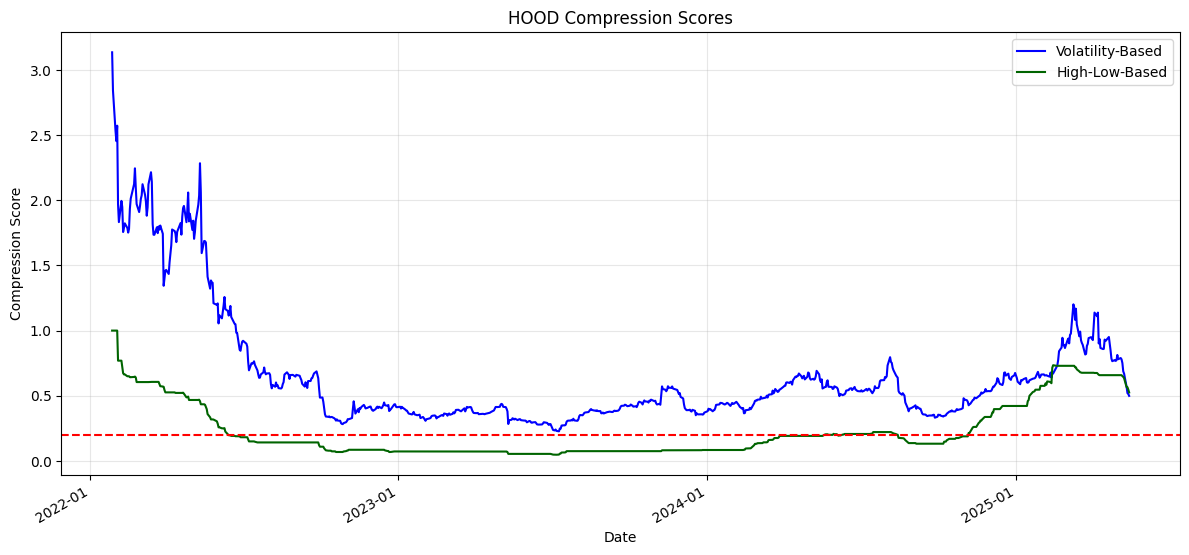

In [110]:
# Cell 10: Plot both compression scores
# Step 9: Plot Both Compression Scores
plt.figure(figsize=(12, 6))
plt.plot(compression_vol.index, compression_vol.values, color='blue', label='Volatility-Based')
plt.plot(compression_range.index, compression_range.values, color='darkgreen', label='High-Low-Based')
plt.axhline(y=0.2, color='red', linestyle='--')
plt.title(f'{Ticker} Compression Scores')
plt.xlabel('Date')
plt.ylabel('Compression Score')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Format dates on x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

plt.show()

In [111]:
compression_range.head()

Ticker,HOOD
Date,
2022-01-27,1.0
2022-01-28,1.0
2022-01-31,1.0
2022-02-01,1.0
2022-02-02,1.0


In [112]:
type(compression_vol)

pandas.core.frame.DataFrame

In [113]:
# Check if the columns are the same
if not compression_vol.columns.equals(compression_range.columns):
    raise ValueError("compression_vol and compression_range must have the same columns.")

# Identify the indices where the condition is met for each column
# Here, we'll assume you want to apply the condition to all columns
# If you want to apply it to specific columns, adjust accordingly


# For a single column, e.g., 'BTC-USD'
condition = (compression_vol[Ticker] < compression_vol_filter) | (compression_range[Ticker] < compression_range_filter)
low_dates_idx = np.where(condition)[0]

# Extract the dates based on the indices
low_dates = compression_vol.index[low_dates_idx]

# Create a DataFrame with the filtered data
filtered_df = pd.DataFrame({
    'date': low_dates,
    'compression_vol': compression_vol[Ticker].iloc[low_dates_idx].values,
    'compression_range': compression_range[Ticker].iloc[low_dates_idx].values
})


# If you have multiple columns and want to apply the condition to each column separately, you can do the following:

# Example for multiple columns
df = filtered_df.copy()

def determine_condition(row):
    if row['compression_vol'] < compression_vol_filter and row['compression_range'] < compression_range_filter:
        return 'Both'
    elif row['compression_vol'] < compression_vol_filter:
        return 'CompressionVol'
    elif row['compression_range'] < compression_range_filter:
        return 'CompressionRange'
    else:
        return 'None'

df['Condition'] = df.apply(determine_condition, axis=1)

# Print the DataFrame with the new condition column
df.head()
df['Condition'].value_counts()


Condition
CompressionRange    347
Name: count, dtype: int64

In [114]:
pd.set_option('display.max_rows', None)

# Set the maximum number of columns to display to None (which means unlimited)
pd.set_option('display.max_columns', None)

# Optionally, you can also set the width to None to allow unlimited width
pd.set_option('display.width', None)

df


,date,compression_vol,compression_range,Condition
0,2022-10-05,0.404573,0.096693,CompressionRange
1,2022-10-06,0.357057,0.088504,CompressionRange
2,2022-10-07,0.340855,0.081575,CompressionRange
3,2022-10-10,0.338314,0.078740,CompressionRange
4,2022-10-11,0.341548,0.078740,CompressionRange
5,2022-10-12,0.335014,0.078740,CompressionRange
6,2022-10-13,0.336590,0.078740,CompressionRange
7,2022-10-14,0.337652,0.073543,CompressionRange
8,2022-10-17,0.327444,0.073543,CompressionRange
9,2022-10-18,0.320702,0.073543,CompressionRange


In [115]:
warning_dates = df['date']
warning_dates = np.array(warning_dates)
warning_dates[0]

np.datetime64('2022-10-05T00:00:00.000000000')

In [116]:

stop_signals = (rolling_vol/np.sqrt(365)) * StopMagnitude
stop_signals.head()

Ticker,HOOD
Date,
2022-01-27,0.082165
2022-01-28,0.082603
2022-01-31,0.083236
2022-02-01,0.083038
2022-02-02,0.082817


In [117]:

data['MA_50'] = data[Ticker].rolling(window=MovingAverage).mean()

data.tail()

Ticker,HOOD,MA_50
Date,,
2025-05-09,54.650002,43.8878
2025-05-12,57.430000,44.0344
2025-05-13,62.570000,44.3480
2025-05-14,61.389999,44.6514
2025-05-15,60.680000,44.9026


In [118]:

data=data.dropna()

In [119]:

data = data.rename(columns={Ticker:'Close'})
data = data.rename(columns= {'MA_50':'SMA_50'})
data.head()

Ticker,Close,SMA_50
Date,,
2021-10-07,41.840000,45.1150
2021-10-08,41.779999,45.2542
2021-10-11,42.070000,45.3926
2021-10-12,40.529999,45.4496
2021-10-13,40.520000,45.3240


-df has a list of dates that are warning signals saying we are in a tight range. (can be converted just to an array of the dates, the scores arent needed)

-Loop through all bitcoin dates, waiting for a warning signal date, once we reach a date, we are now in a range.

-Once we are in a range, we stop looking for the warning date signals, now we just look for when the price is going to break ut of the range

-The range will be the max and min of the last 60 days (range_window). 
If price breaks above, we enter our long strategy, if it breaks below, we enter our short strategy. We also have a stop strategy to prevent losses.

-Long strategy Exit: Exit when price below 50 day moving average
-Short strategy Exit: Exit when price above 50 day moving average
-Stop strategy: StopSignal is a dataframe of dates and percents. Once we are in a long strategy, if the price has gone down more than the stop signal, cut our losses and exit, same for short strategy but if it goes up more thna the StopSignal we also exit and cut our losses.  

-Once we exit either strategy, we immediatly start looking for a warning signal again to repeat the whole process (start looking the same day as the exit not the day after)

-Once the Backtest is complete, seperate statistics will be provided for long strategy and short strategy. 
-Additionally, make a visulizations that shows the bitcoin chart, and a symbol for when we entered and exited. 

Statistics will include: Sharpe Ratio, Winning percentage, total return, max drawdown

In [120]:
# Cell 12: Save results to CSV (optional)
# Save the results to a CSV file
#filtered_df.to_csv('bitcoin_compression_low_dates.csv', index=False)
#print("Results saved to 'bitcoin_compression_low_dates.csv'")

In [121]:
class RangeboundBacktest:
    def __init__(self, price_data, warning_dates, stop_signals, range_window=60):
        self.data = price_data
        self.warning_dates = warning_dates
        self.stop_signals = stop_signals
        self.range_window = range_window
        
        # Get the price column name
        self.price_col = 'Close' if 'Close' in self.data.columns else self.data.columns[0]
        
        # Initialize state variables
        self.in_range = False
        self.position = None  # None, 'long', or 'short'
        self.entry_price = 0
        self.range_high = 0
        self.range_low = 0
        
        # Performance tracking
        self.trades = []
        self.equity_curve = []
        
        # Debug counters
        self.warning_signals_detected = 0
        self.range_entries = 0
        self.breakouts_detected = 0
        
    def run_backtest(self):
        print(f"Starting backtest with {len(self.data)} price points and {len(self.warning_dates)} warning dates")
        print(f"First few warning dates: {self.warning_dates[:5]}")
        print(f"First few price dates: {self.data.index[:5]}")
        
        # Convert warning dates to the same format as price data index
        # This is crucial for date matching
        formatted_warning_dates = []
        for date in self.warning_dates:
            if isinstance(date, str):
                formatted_date = pd.to_datetime(date)
            elif isinstance(date, pd.Timestamp):
                formatted_date = date
            else:
                formatted_date = pd.Timestamp(date)
            formatted_warning_dates.append(formatted_date)
        
        self.warning_dates = formatted_warning_dates
        
        # Iterate through each date in the price data
        for i, row in self.data.iterrows():
            current_date = i  # i is the index, which should be the date
            current_price = row[self.price_col]
            
            # Check if we're not in a range and today is a warning date
            if not self.in_range:
                # Convert current_date to match warning_dates format if needed
                if current_date in self.warning_dates:
                    print(f"Warning signal detected on {current_date}")
                    self.warning_signals_detected += 1
                    self.enter_range_mode(current_date)
            
            # If we're in range mode but have no position, check for breakouts
            elif self.in_range and self.position is None:
                # Check if price breaks out of the range
                if current_price > self.range_high or current_price < self.range_low:
                    print(f"Potential breakout on {current_date}, price: {current_price}, range: [{self.range_low}, {self.range_high}]\n")
                    
                self.check_for_breakout(current_date, current_price)
            
            # If we have a position, check for exit conditions
            elif self.position is not None:
                self.check_for_exit(current_date, current_price)
        
        # Print debug information
        print(f"\nBacktest completed")
        print(f"Warning signals detected: {self.warning_signals_detected}")
        print(f"Range entries: {self.range_entries}")
        print(f"Breakouts detected: {self.breakouts_detected}")
        print(f"Total trades: {len([t for t in self.trades if t['type'] == 'exit'])}")
                
        # Calculate final performance metrics
        return self.calculate_performance()
    
    def enter_range_mode(self, date):
        self.in_range = True
        self.range_entries += 1
        
        # Define range as max and min of last 60 days
        past_data = self.data.loc[:date].tail(self.range_window)
        self.range_high = past_data[self.price_col].max()
        self.range_low = past_data[self.price_col].min()
        
        print(f"Entered range mode on {date}: Low={self.range_low}, High={self.range_high}\n")
    
    def check_for_breakout(self, date, price):
        # Long entry: price breaks above the range
        if price > self.range_high:
            self.position = 'long'
            self.entry_price = price
            self.entry_date = date
            self.breakouts_detected += 1
            self.trades.append({
                'type': 'entry',
                'position': 'long',
                'date': date,
                'price': price
            })
            print(f"LONG entry on {date} at {price} (breakout above {self.range_high})\n")
        
        # Short entry: price breaks below the range
        elif price < self.range_low:
            self.position = 'short'
            self.entry_price = price
            self.entry_date = date
            self.breakouts_detected += 1
            self.trades.append({
                'type': 'entry',
                'position': 'short',
                'date': date,
                'price': price
            })
            print(f"SHORT entry on {date} at {price} (breakout below {self.range_low})\n")
    
    def check_for_exit(self, date, price):
        current_row = self.data.loc[date]
        
        # Get current stop level
        stop_level = self.get_stop_level(date)
        
        exit_reason = None
        
        # Long exit conditions
        if self.position == 'long':
            # Exit when price below 50-day MA
            if price < current_row['SMA_50']:
                exit_reason = 'SMA_exit'
            # Stop loss
            elif price < self.entry_price * (1 - stop_level):
                exit_reason = 'stop_loss'
        
        # Short exit conditions
        elif self.position == 'short':
            # Exit when price above 50-day MA
            if price > current_row['SMA_50']:
                exit_reason = 'SMA_exit'
            # Stop loss
            elif price > self.entry_price * (1 + stop_level):
                exit_reason = 'stop_loss'
                
        # If we have an exit reason, exit the position
        if exit_reason:
            self.exit_position(date, price, exit_reason)
    
    def exit_position(self, date, price, reason):
        profit_pct = self.calculate_profit(price)
        
        self.trades.append({
            'type': 'exit',
            'position': self.position,
            'date': date,
            'price': price,
            'reason': reason,
            'profit_pct': profit_pct
        })
        
        print(f"EXIT {self.position} on {date} at {price} (reason: {reason}, profit: {profit_pct:.2%})\n")
        
        # Reset position
        self.position = None
        
        # Continue looking for new range signals
        self.in_range = False
    
    def calculate_profit(self, exit_price):
        if self.position == 'long':
            return (exit_price - self.entry_price) / self.entry_price
        elif self.position == 'short':
            return (self.entry_price - exit_price) / self.entry_price
        return 0
    
    def get_stop_level(self, date):
        # Default stop level
        default_stop = 0.05  # 5%
        
        # If stop_signals is None or empty, return default
        if self.stop_signals is None or len(self.stop_signals) == 0:
            return default_stop
            
        try:
            # Try to find the appropriate stop level for the current date
            if isinstance(self.stop_signals.index, pd.DatetimeIndex):
                # Date is the index
                stop_row = self.stop_signals.loc[:date].iloc[-1] if not self.stop_signals.loc[:date].empty else None
            else:
                # Assume there's a 'Date' column
                date_col = [col for col in self.stop_signals.columns if 'date' in col.lower()]
                if date_col:
                    date_column = date_col[0]
                    stop_row = self.stop_signals[self.stop_signals[date_column] <= date].iloc[-1] if not self.stop_signals[self.stop_signals[date_column] <= date].empty else None
                else:
                    return default_stop
            
            # Get the stop percentage column
            stop_percent_col = [col for col in self.stop_signals.columns if 'percent' in col.lower()]
            if stop_percent_col and stop_row is not None:
                return stop_row[stop_percent_col[0]]
            else:
                return default_stop
        except Exception as e:
            print(f"Error getting stop level: {e}")
            return default_stop
    
    def calculate_performance(self):
        exit_trades = [t for t in self.trades if t['type'] == 'exit']
        long_trades = [t for t in exit_trades if t['position'] == 'long']
        short_trades = [t for t in exit_trades if t['position'] == 'short']
        
        return {
            'long': self.calculate_metrics(long_trades),
            'short': self.calculate_metrics(short_trades),
            'overall': self.calculate_metrics(exit_trades)
        }
    
    def calculate_metrics(self, trades):
        if not trades:
            return {'win_rate': 0, 'total_return': 0, 'sharpe': 0, 'max_drawdown': 0, 'trade_count': 0}
        
        # Calculate win rate
        winning_trades = [t for t in trades if t.get('profit_pct', 0) > 0]
        win_rate = len(winning_trades) / len(trades) if trades else 0
        
        # Calculate returns
        profits = [t.get('profit_pct', 0) for t in trades]
        total_return = sum(profits)
        
        # Calculate Sharpe ratio (assuming risk-free rate of 0)
        if profits and len(profits) > 1:
            sharpe = np.mean(profits) / np.std(profits) * np.sqrt(252) if np.std(profits) > 0 else 0
        else:
            sharpe = 0
        
        # Calculate max drawdown
        # (this is a simplified approach)
        if profits:
            cumulative = np.cumprod([1 + p for p in profits])
            max_dd = 0
            peak = cumulative[0]
            for value in cumulative:
                if value > peak:
                    peak = value
                dd = (peak - value) / peak if peak > 0 else 0
                max_dd = max(max_dd, dd)
        else:
            max_dd = 0
        
        return {
            'win_rate': win_rate,
            'total_return': total_return,
            'sharpe': sharpe,
            'max_drawdown': max_dd,
            'trade_count': len(trades)
        }

In [122]:
def visualize_results(data, backtest_results):
    # Create a figure
    plt.figure(figsize=(15, 10))
    
    # Plot BTC price
    plt.subplot(2, 1, 1)
    plt.plot(data.index, data['Close'], label='BTC Price')
    
    # Plot 50-day MA
    plt.plot(data.index, data['SMA_50'], label='50-day MA', alpha=0.7)
    
    # Plot entry and exit points
    entries = [t for t in backtest_results.trades if t['type'] == 'entry']
    exits = [t for t in backtest_results.trades if t['type'] == 'exit']
    
    # Plot long entries
    long_entries = [t for t in entries if t['position'] == 'long']
    plt.scatter([t['date'] for t in long_entries], 
                [t['price'] for t in long_entries], 
                marker='^', color='green', s=100, label='Long Entry')
    
    # Plot short entries
    short_entries = [t for t in entries if t['position'] == 'short']
    plt.scatter([t['date'] for t in short_entries], 
                [t['price'] for t in short_entries], 
                marker='v', color='red', s=100, label='Short Entry')
    
    # Plot exits
    plt.scatter([t['date'] for t in exits], 
                [t['price'] for t in exits], 
                marker='o', color='black', s=80, label='Exit')
    
    plt.title('Bitcoin Price with Trading Signals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot equity curve
    plt.subplot(2, 1, 2)
    equity_curve = [1 + t.get('profit_pct', 0) for t in backtest_results.trades if 'profit_pct' in t]
    equity_curve = np.cumprod(equity_curve)
    plt.plot(equity_curve, label='Equity Curve')
    plt.title('Strategy Equity Curve')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print performance metrics
    print("Performance Summary:")
    print("-------------------")
    print(f"Long Strategy:")
    print(f"  Win Rate: {backtest_results['long']['win_rate']:.2%}")
    print(f"  Total Return: {backtest_results['long']['total_return']:.2%}")
    print(f"  Sharpe Ratio: {backtest_results['long']['sharpe']:.2f}")
    print(f"  Max Drawdown: {backtest_results['long']['max_drawdown']:.2%}")
    print(f"  Number of Trades: {backtest_results['long']['trade_count']}")
    print("")
    print(f"Short Strategy:")
    print(f"  Win Rate: {backtest_results['short']['win_rate']:.2%}")
    print(f"  Total Return: {backtest_results['short']['total_return']:.2%}")
    print(f"  Sharpe Ratio: {backtest_results['short']['sharpe']:.2f}")
    print(f"  Max Drawdown: {backtest_results['short']['max_drawdown']:.2%}")
    print(f"  Number of Trades: {backtest_results['short']['trade_count']}")

In [123]:
def run_backtest():
    # Use existing data from the notebook
    price_data = data.copy()  # This should be the BTC price data from your notebook
    
    # Calculate 50-day MA if it doesn't exist
    if 'SMA_50' not in price_data.columns:
        price_col = 'Close' if 'Close' in price_data.columns else price_data.columns[0]
        price_data['SMA_50'] = price_data[price_col].rolling(window=50).mean().dropna()
    
    # Make sure price_data index is datetime
    if not isinstance(price_data.index, pd.DatetimeIndex):
        price_data.index = pd.to_datetime(price_data.index)
    
    # Get warning dates (adjust this based on where your warning dates are stored)
    # If filtered_df contains the warning signals:
    if 'filtered_df' in globals():
        warning_dates = filtered_df['date'].tolist() if 'date' in filtered_df.columns else filtered_df.index.tolist()
    else:
        # Create a sample set of warning dates based on the condition in the notebook
        condition = (compression_vol[Ticker] < 0.25) | (compression_range[Ticker] < 0.05)
        warning_dates = compression_vol.index[condition].tolist()
    
    print(f"Found {len(warning_dates)} warning dates")
    
    # Create stop signal DataFrame if it doesn't exist
    
    
    # Initialize and run backtest
    backtest = RangeboundBacktest(
        price_data=price_data,
        warning_dates=warning_dates,
        stop_signals=stop_signals,
        range_window = range_window
    )
    results = backtest.run_backtest()
    
    return results, backtest

# Run the backtest
results, backtest = run_backtest()

# Display the results


Found 347 warning dates
Starting backtest with 905 price points and 347 warning dates
First few warning dates: [Timestamp('2022-10-05 00:00:00'), Timestamp('2022-10-06 00:00:00'), Timestamp('2022-10-07 00:00:00'), Timestamp('2022-10-10 00:00:00'), Timestamp('2022-10-11 00:00:00')]
First few price dates: DatetimeIndex(['2021-10-07', '2021-10-08', '2021-10-11', '2021-10-12',
               '2021-10-13'],
              dtype='datetime64[ns]', name='Date', freq=None)
Warning signal detected on 2022-10-05 00:00:00
Entered range mode on 2022-10-05 00:00:00: Low=6.889999866485596, High=13.029999732971191

Potential breakout on 2023-07-19 00:00:00, price: 13.119999885559082, range: [6.889999866485596, 13.029999732971191]

LONG entry on 2023-07-19 00:00:00 at 13.119999885559082 (breakout above 13.029999732971191)

EXIT long on 2023-07-27 00:00:00 at 12.229999542236328 (reason: stop_loss, profit: -6.78%)

Warning signal detected on 2023-07-28 00:00:00
Entered range mode on 2023-07-28 00:00:00: L

In [124]:
def display_results(backtest, results):
    """
    Display and visualize backtest results
    """
    # Print performance metrics
    print("\n===== PERFORMANCE SUMMARY =====\n")
    
    print("LONG STRATEGY:")
    print(f"Win Rate: {results['long']['win_rate']:.2%}")
    print(f"Total Return: {results['long']['total_return']:.2%}")
    print(f"Sharpe Ratio: {results['long']['sharpe']:.2f}")
    print(f"Max Drawdown: {results['long']['max_drawdown']:.2%}")
    print(f"Number of Trades: {results['long']['trade_count']}")
    
    print("\nSHORT STRATEGY:")
    print(f"Win Rate: {results['short']['win_rate']:.2%}")
    print(f"Total Return: {results['short']['total_return']:.2%}")
    print(f"Sharpe Ratio: {results['short']['sharpe']:.2f}")
    print(f"Max Drawdown: {results['short']['max_drawdown']:.2%}")
    print(f"Number of Trades: {results['short']['trade_count']}")
    
    print("\nOVERALL PERFORMANCE:")
    print(f"Win Rate: {results['overall']['win_rate']:.2%}")
    print(f"Total Return: {results['overall']['total_return']:.2%}")
    print(f"Sharpe Ratio: {results['overall']['sharpe']:.2f}")
    print(f"Max Drawdown: {results['overall']['max_drawdown']:.2%}")
    print(f"Number of Trades: {results['overall']['trade_count']}")
    
    # Visualize the results
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.dates import DateFormatter
    
    # Plot the Bitcoin price and trades
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [3, 1]})
    
    # Get the price data and column name
    price_data = backtest.data
    price_col = 'Close' if 'Close' in price_data.columns else price_data.columns[0]
    
    # Plot Bitcoin price
    ax1.plot(price_data.index, price_data[price_col], label='Price', color='blue', alpha=0.7)
    ax1.plot(price_data.index, price_data['SMA_50'], label='50-day MA', color='orange', alpha=0.5)
    
    # Plot trade entries and exits
    entry_trades = [t for t in backtest.trades if t['type'] == 'entry']
    exit_trades = [t for t in backtest.trades if t['type'] == 'exit']
    
    # Plot long entries
    long_entries = [t for t in entry_trades if t['position'] == 'long']
    if long_entries:
        entry_dates = [t['date'] for t in long_entries]
        entry_prices = [t['price'] for t in long_entries]
        ax1.scatter(entry_dates, entry_prices, marker='^', color='green', s=100, label='Long Entry')
    
    # Plot short entries
    short_entries = [t for t in entry_trades if t['position'] == 'short']
    if short_entries:
        entry_dates = [t['date'] for t in short_entries]
        entry_prices = [t['price'] for t in short_entries]
        ax1.scatter(entry_dates, entry_prices, marker='v', color='red', s=100, label='Short Entry')
    
    # Plot exits
    if exit_trades:
        exit_dates = [t['date'] for t in exit_trades]
        exit_prices = [t['price'] for t in exit_trades]
        ax1.scatter(exit_dates, exit_prices, marker='o', color='black', s=80, label='Exit')
    
    # Formatting for the price chart
    ax1.set_title(f'{Ticker} Price with Entry/Exit Points', fontsize=16)
    ax1.set_ylabel('Price ($)', fontsize=14)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot equity curve
    if exit_trades:
        profits = [t.get('profit_pct', 0) for t in exit_trades]
        cumulative = np.cumprod([1 + p for p in profits])
        
        # Create an array of dates for the equity curve
        dates = [t['date'] for t in exit_trades]
        
        ax2.plot(dates, cumulative, label='Equity Curve', color='green')
        ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5)
        ax2.set_title('Strategy Equity Curve', fontsize=16)
        ax2.set_ylabel('Equity Growth (starting at 1)', fontsize=14)
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Return a summary dictionary for easy access
    return {
        'total_trades': results['overall']['trade_count'],
        'win_rate': results['overall']['win_rate'],
        'total_return': results['overall']['total_return'],
        'sharpe': results['overall']['sharpe'],
        'max_drawdown': results['overall']['max_drawdown']
    }


===== PERFORMANCE SUMMARY =====

LONG STRATEGY:
Win Rate: 33.33%
Total Return: 11.43%
Sharpe Ratio: 4.18
Max Drawdown: 6.07%
Number of Trades: 3

SHORT STRATEGY:
Win Rate: 0.00%
Total Return: -7.19%
Sharpe Ratio: 0.00
Max Drawdown: 0.00%
Number of Trades: 1

OVERALL PERFORMANCE:
Win Rate: 25.00%
Total Return: 4.24%
Sharpe Ratio: 1.26
Max Drawdown: 12.83%
Number of Trades: 4


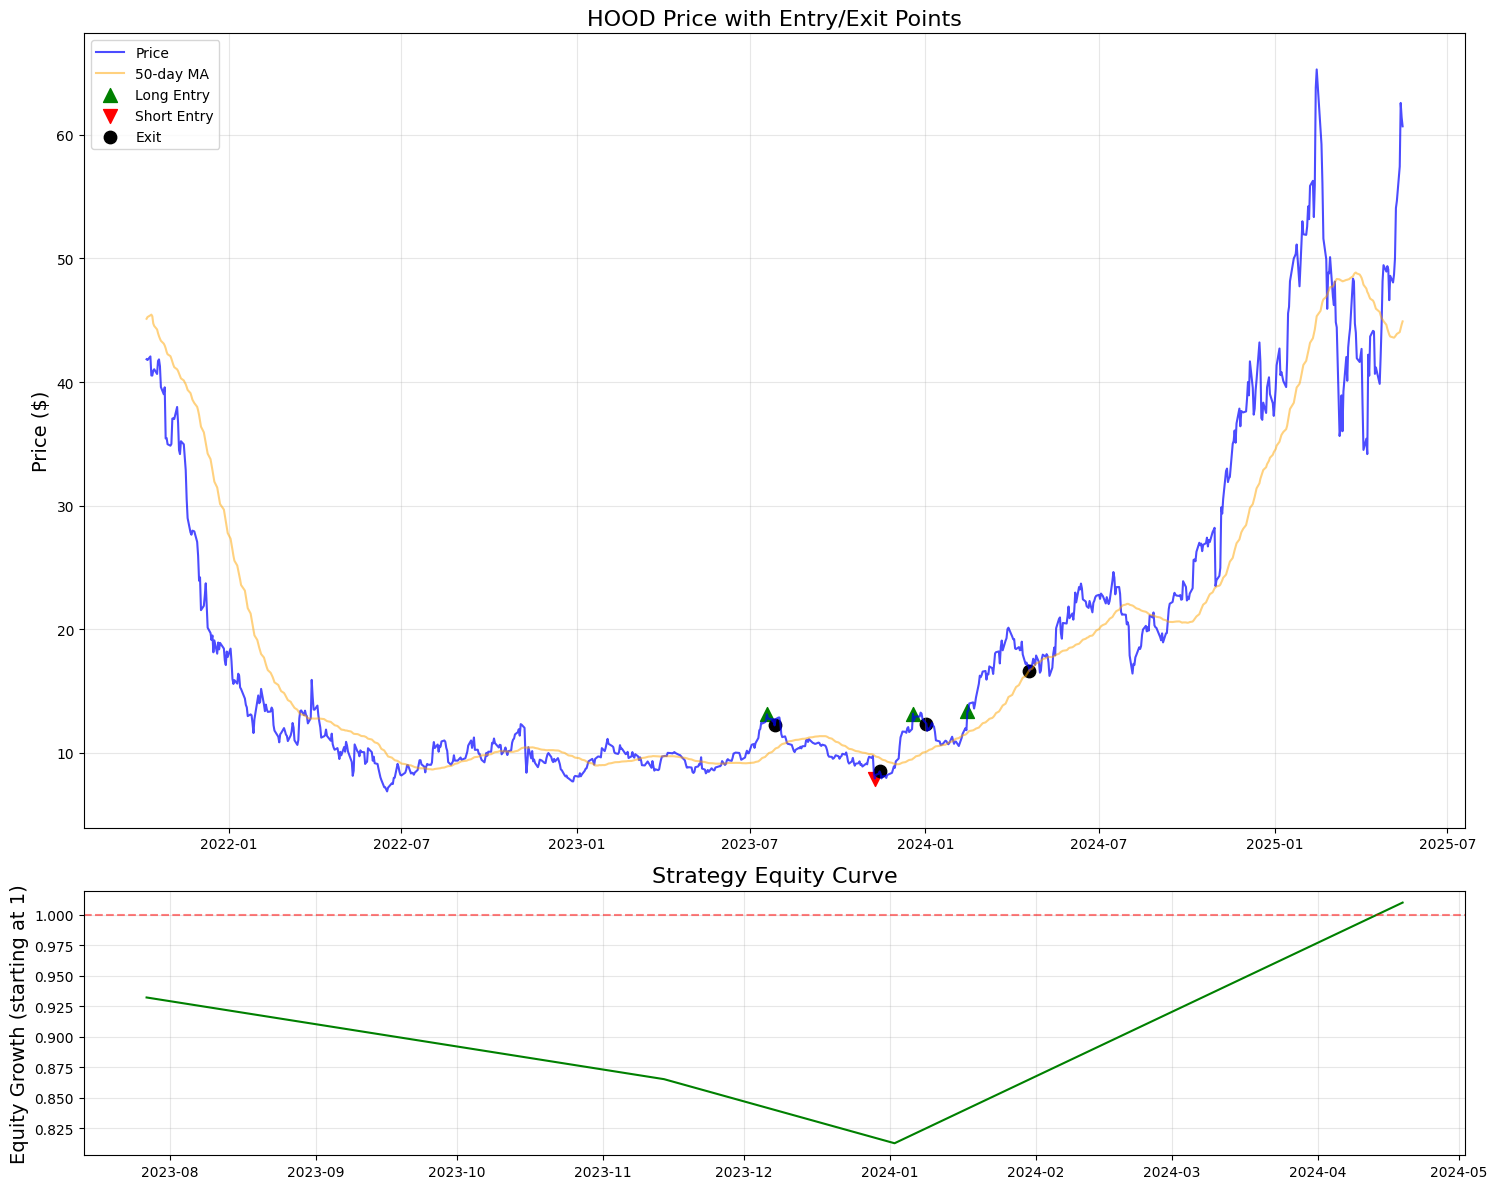

In [125]:
summary = display_results(backtest, results)